In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML



C:\Users\asus\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=60

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/skin_cancer_detection_webapp - Copy/Dataset1",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 11906 files belonging to 15 classes.


In [4]:
len(dataset)

373

In [5]:
class_names = dataset.class_names
class_names

['Acne and Rosacea Photos',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Atopic Dermatitis Photos',
 'Bullous Disease Photos',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Eczema Photos',
 'Exanthems and Drug Eruptions',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Herpes HPV and other STDs Photos',
 'Light Diseases and Disorders of Pigmentation',
 'Lupus and other Connective Tissue diseases',
 'Melanoma Skin Cancer Nevi and Moles',
 'Nail Fungus and other Nail Disease',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Psoriasis pictures Lichen Planus and related diseases']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 5 10  0 12 11  1 12 10  1  4  3  5  0  1 11  1  3  1 10  5  1 14  9 11
  1  8  7 14 14  1 11  5]


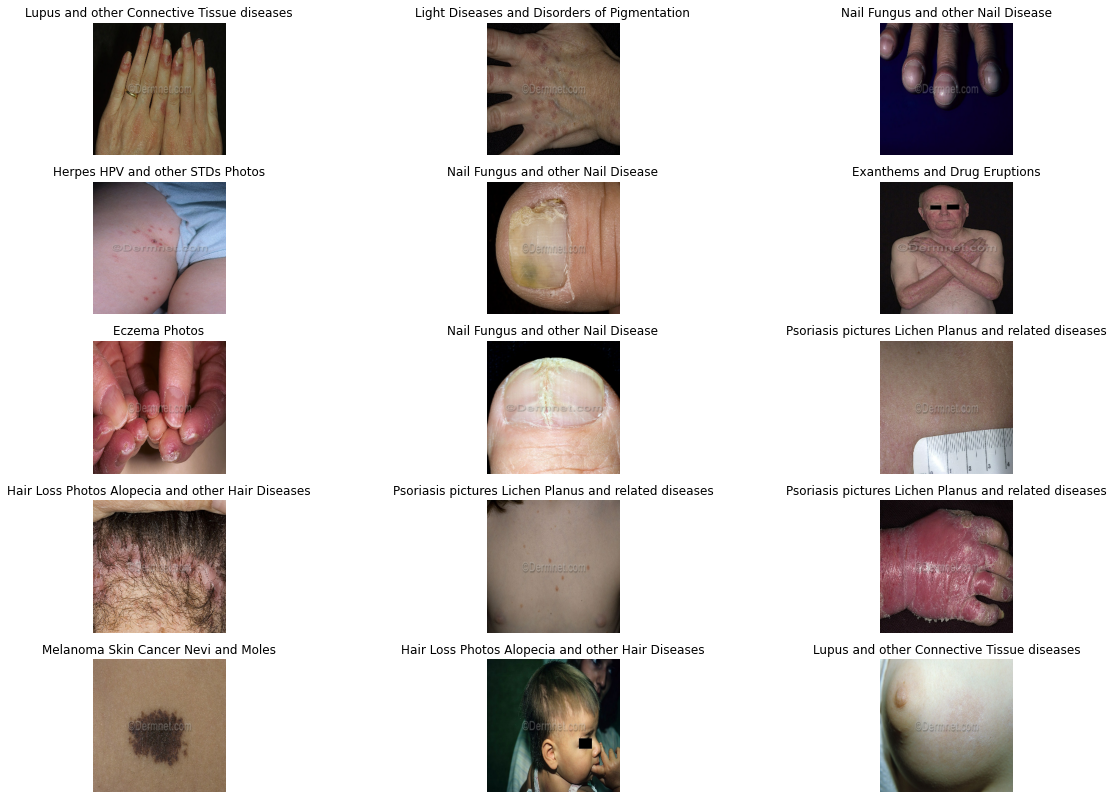

In [7]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(7, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

298

In [11]:
len(val_ds)

37

In [12]:
len(test_ds)

38

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
import numpy as np
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.07879902 0.10232843 0.08664215]
  [0.07879902 0.10232843 0.08664215]
  [0.07879902 0.10232843 0.08664215]
  ...
  [0.8066825  0.66733664 0.51762   ]
  [0.80727637 0.6700215  0.5210018 ]
  [0.7973937  0.6601388  0.5111192 ]]

 [[0.07843138 0.10196079 0.08627451]
  [0.07843138 0.10196079 0.08627451]
  [0.07843138 0.10196079 0.08627451]
  ...
  [0.8236108  0.6745912  0.52165   ]
  [0.80432343 0.663461   0.5132389 ]
  [0.7976268  0.6603719  0.5113523 ]]

 [[0.07634804 0.09987745 0.08419117]
  [0.07634804 0.09987745 0.08419117]
  [0.07634804 0.09987745 0.08419117]
  ...
  [0.7880165  0.6389969  0.48605573]
  [0.8345435  0.68552387 0.5325827 ]
  [0.82492846 0.6759088  0.52296764]]

 ...

 [[0.94339    0.8335861  0.6806449 ]
  [0.9469394  0.8371355  0.68419427]
  [0.94394916 0.83414525 0.681204  ]
  ...
  [0.15395723 0.18140821 0.15003566]
  [0.14549178 0.17294276 0.14157021]
  [0.15608557 0.18353654 0.152164  ]]

 [[0.9540441  0.83639705 0.68737745]
  [0.95906866 0.84142154 0.69240195]


In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
BATCH_SIZE

32

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=60,
)

Epoch 1/60


298/298 [==============================] - 414s 1s/step - loss: 2.5231 - accuracy: 0.1675 - val_loss: 2.4060 - val_accuracy: 0.2227
Epoch 2/60
298/298 [==============================] - 258s 865ms/step - loss: 2.3763 - accuracy: 0.2303 - val_loss: 2.3212 - val_accuracy: 0.2513
Epoch 3/60
298/298 [==============================] - 211s 709ms/step - loss: 2.2830 - accuracy: 0.2677 - val_loss: 2.1805 - val_accuracy: 0.3215
Epoch 4/60
298/298 [==============================] - 208s 697ms/step - loss: 2.2173 - accuracy: 0.2944 - val_loss: 2.1416 - val_accuracy: 0.3154
Epoch 5/60
298/298 [==============================] - 207s 696ms/step - loss: 2.1611 - accuracy: 0.3120 - val_loss: 2.0817 - val_accuracy: 0.3510
Epoch 6/60
298/298 [==============================] - 222s 744ms/step - loss: 2.1065 - accuracy: 0.3303 - val_loss: 2.0335 - val_accuracy: 0.3579
Epoch 7/60
298/298 [==============================] - 206s 692ms/step - loss: 2.0503 - accuracy: 0.3473 - val_loss: 1.9481 - 

In [55]:
scores = model.evaluate(test_ds)

38/38 [==============================] - 12s 318ms/step - loss: 1.7185 - accuracy: 0.7821


In [56]:
scores

[1.7184585332870483, 0.7820723652839661]

In [57]:
history.params

{'verbose': 1, 'epochs': 60, 'steps': 298}

In [58]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [59]:
type(history.history['loss'])

list

In [60]:
len(history.history['loss'])

60

In [61]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.5231356620788574,
 2.3762683868408203,
 2.282972812652588,
 2.217315196990967,
 2.1610617637634277]

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [63]:
acc

[0.1674731820821762,
 0.23027561604976654,
 0.2677256464958191,
 0.29444560408592224,
 0.3120134770870209,
 0.3303177058696747,
 0.34725436568260193,
 0.36640018224716187,
 0.3922785520553589,
 0.4143698811531067,
 0.42909741401672363,
 0.4525562822818756,
 0.4734904170036316,
 0.503050684928894,
 0.5270355343818665,
 0.5498632192611694,
 0.5667999386787415,
 0.6025667786598206,
 0.6136124730110168,
 0.6399116516113281,
 0.6593730449676514,
 0.6745213270187378,
 0.7001893520355225,
 0.7026088833808899,
 0.7158636450767517,
 0.744687557220459,
 0.7554176449775696,
 0.7710919380187988,
 0.782453179359436,
 0.7931832671165466,
 0.7987586855888367,
 0.8109614849090576,
 0.8162213563919067,
 0.8247422575950623,
 0.8323164582252502,
 0.8397853970527649,
 0.8416789174079895,
 0.8456764221191406,
 0.8546181321144104,
 0.8649274110794067,
 0.8649274110794067,
 0.8715547919273376,
 0.8755522966384888,
 0.8753418922424316,
 0.8625078797340393,
 0.893751323223114,
 0.8911213874816895,
 0.890490233

In [64]:
val_acc


[0.22270363569259644,
 0.25129982829093933,
 0.32149046659469604,
 0.3154246211051941,
 0.35095319151878357,
 0.3578856289386749,
 0.37954938411712646,
 0.39168110489845276,
 0.41247832775115967,
 0.43587520718574524,
 0.44800692796707153,
 0.47660312056541443,
 0.4870017468929291,
 0.499133437871933,
 0.5268630981445312,
 0.5563258528709412,
 0.5519930720329285,
 0.596187174320221,
 0.6117851138114929,
 0.6143847703933716,
 0.6299826502799988,
 0.6403812766075134,
 0.6611785292625427,
 0.6525130271911621,
 0.6689774990081787,
 0.6880415678024292,
 0.6819757223129272,
 0.7001733183860779,
 0.7287694811820984,
 0.7521663904190063,
 0.7287694811820984,
 0.746967077255249,
 0.6915078163146973,
 0.7409012317657471,
 0.731369137763977,
 0.7339687943458557,
 0.7781628966331482,
 0.7071056962013245,
 0.7816291451454163,
 0.7816291451454163,
 0.7755632400512695,
 0.7755632400512695,
 0.7946273684501648,
 0.7911611795425415,
 0.7868283987045288,
 0.7720970511436462,
 0.8206239342689514,
 0.7833

In [65]:
max(val_acc)

0.8206239342689514

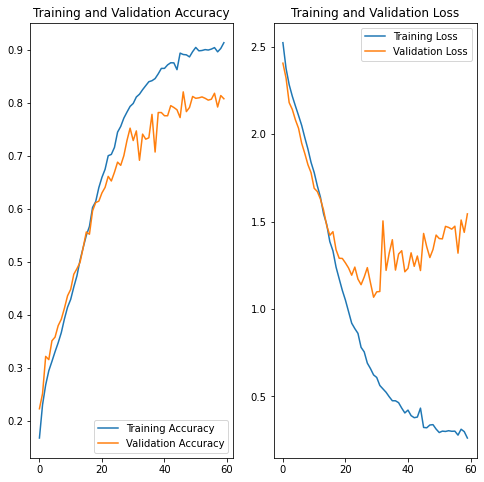

In [66]:
EPOCHS =60
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: Atopic Dermatitis Photos
1/1 [==============================] - 0s 390ms/step
predicted label: Atopic Dermatitis Photos


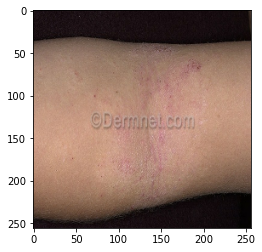

In [67]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [68]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 88ms/step


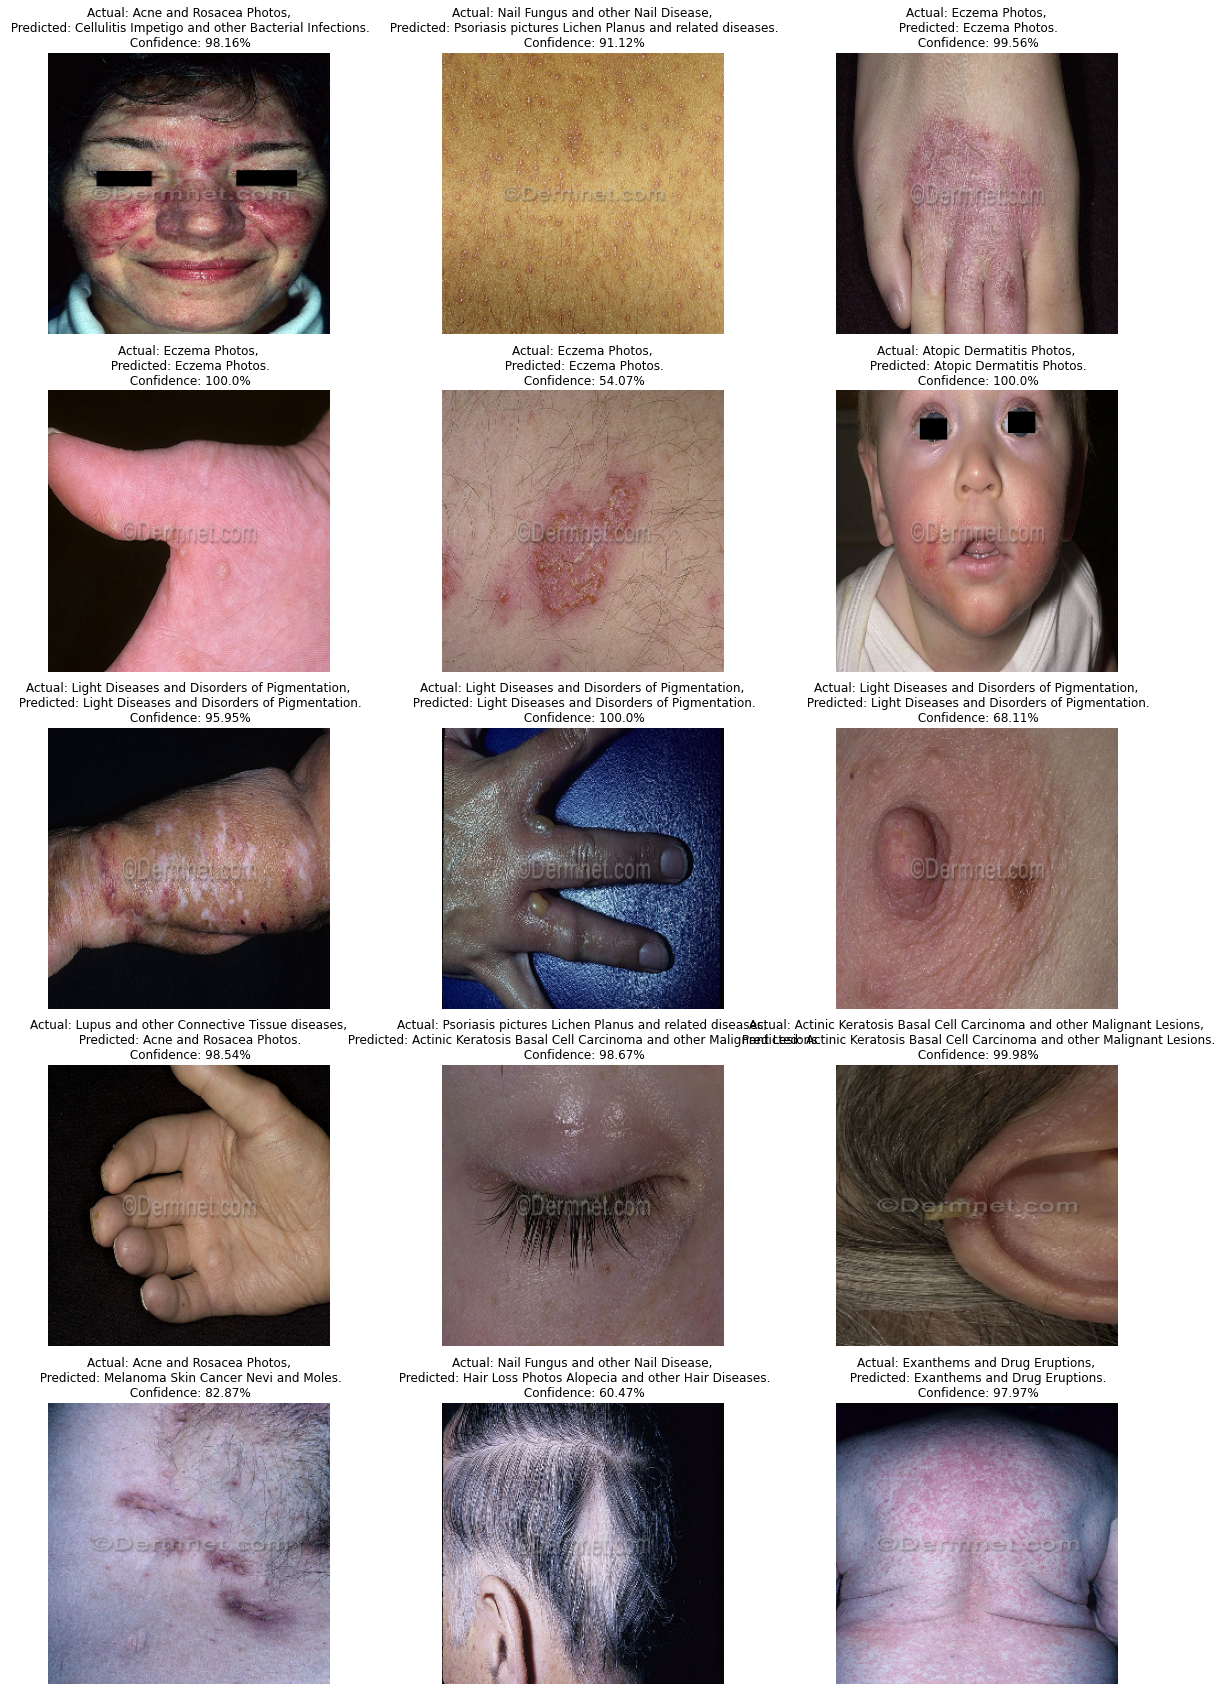

In [69]:
plt.figure(figsize=(20, 30))
for images, labels in test_ds.take(1):
    for i in range(15):
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [75]:
# import os
# model_version=max([int(i) for i in os.listdir("../Skin disease/models") + [0]])+1
# model.save(f"../Skin disease/models/{model_version}")

In [78]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('C:/skin_cancer_detection_webapp/models/model_v1.h5')

In [80]:
import os
model_version=max([int(i) for i in os.listdir("'C:/skin_cancer_detection_webapp/models") + [0]])+1
model.save(f"'C:/skin_cancer_detection_webapp/models/{model_version}")

OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: "'C:/skin_cancer_detection_webapp/models"